In [7]:
import numpy as np
import pandas as pd
import scipy.io as sio 
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers


## Data preprocessing

In [8]:
new_train_path = 'Dataset/new_cars_train/'
new_test_path = 'Dataset/new_cars_test/'


train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,
        validation_split = 0.15,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        new_train_path,
        target_size=(224, 224),
        batch_size=16,
        seed = 42,
        shuffle = True,
        subset = 'training',
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        new_train_path,
        target_size=(224, 224),
        batch_size=16,
        seed = 42,
        shuffle = True,
        subset = 'validation',
        class_mode='categorical')

Found 7018 images belonging to 196 classes.
Found 1126 images belonging to 196 classes.


## Fine-tune using EfficientnetB0

In [3]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input


In [4]:
# loading pretrained conv base model
conv_base = Net(weights="imagenet", include_top=False)
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False


efficientnet_model = Sequential()
efficientnet_model.add(conv_base)

efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512))
efficientnet_model.add(Activation('relu'))
efficientnet_model.add(Dropout(0.2))
efficientnet_model.add(Dense(196, activation='softmax'))

efficientnet_model.compile(optimizers.rmsprop(lr=0.0001),
    loss="categorical_crossentropy", metrics=["accuracy"])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = efficientnet_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=60)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
438/438 [==============================] - 352s 805ms/step - loss: 4.8458 - acc: 0.0755 - val_loss: 3.4712 - val_acc: 0.2527
Epoch 2/60
438/438 [==============================] - 345s 787ms/step - loss: 2.6404 - acc: 0.3930 - val_loss: 2.2349 - val_acc: 0.4577
Epoch 3/60
438/438 [==============================] - 344s 784ms/step - loss: 1.4124 - acc: 0.6438 - val_loss: 1.8959 - val_acc: 0.5631
Epoch 4/60
438/438 [==============================] - 344s 785ms/step - loss: 0.8662 - acc: 0.7704 - val_loss: 1.6429 - val_acc: 0.6189
Epoch 5/60
438/438 [==================

Epoch 50/60
438/438 [==============================] - 345s 787ms/step - loss: 0.0876 - acc: 0.9790 - val_loss: 1.7688 - val_acc: 0.7766
Epoch 51/60
438/438 [==============================] - 344s 785ms/step - loss: 0.0948 - acc: 0.9792 - val_loss: 1.7092 - val_acc: 0.7712
Epoch 52/60
438/438 [==============================] - 343s 784ms/step - loss: 0.0941 - acc: 0.9776 - val_loss: 1.6866 - val_acc: 0.7784
Epoch 53/60
438/438 [==============================] - 344s 786ms/step - loss: 0.1050 - acc: 0.9795 - val_loss: 1.7987 - val_acc: 0.7856
Epoch 54/60
438/438 [==============================] - 345s 788ms/step - loss: 0.0839 - acc: 0.9808 - val_loss: 1.8605 - val_acc: 0.7838
Epoch 55/60
438/438 [==============================] - 346s 789ms/step - loss: 0.0993 - acc: 0.9800 - val_loss: 1.7539 - val_acc: 0.7784
Epoch 56/60
438/438 [==============================] - 344s 786ms/step - loss: 0.0894 - acc: 0.9803 - val_loss: 1.9738 - val_acc: 0.7847
Epoch 57/60
438/438 [====================

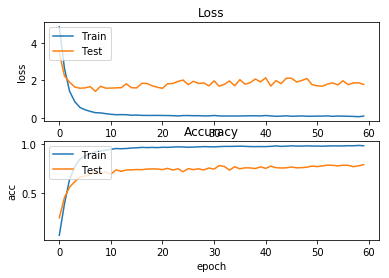

In [5]:
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save .h5

In [6]:
efficientnet_model.save('effnet_final.h5')

## Load model

In [100]:
from keras.models import load_model

model = load_model('effnet_final.h5')

## Validate with train data set

In [101]:
STEPS=validation_generator.n//validation_generator.batch_size
prediction = model.predict_generator(validation_generator, steps=STEPS)

In [102]:
prediction

array([[2.3028976e-20, 4.5541049e-22, 2.6419231e-23, ..., 1.6045340e-18,
        1.6567474e-21, 2.2569010e-19],
       [9.3769302e-25, 3.2833261e-38, 9.1749126e-28, ..., 7.4685132e-29,
        1.9536198e-31, 4.3643962e-29],
       [1.5654055e-14, 3.1293363e-15, 9.8400968e-01, ..., 3.0494077e-12,
        2.1793943e-14, 7.0962163e-15],
       ...,
       [2.1817236e-13, 1.5321895e-15, 6.8714821e-09, ..., 1.8089885e-13,
        7.1005967e-16, 1.5541225e-08],
       [3.8783430e-37, 0.0000000e+00, 1.3034912e-28, ..., 6.8442472e-30,
        8.8854459e-36, 1.3949456e-37],
       [9.7163031e-25, 3.8959457e-19, 1.0339355e-25, ..., 1.6732927e-13,
        1.2142184e-18, 3.1089780e-25]], dtype=float32)

In [103]:
score = model.evaluate_generator(validation_generator, steps = 10)

In [104]:
print('Loss:',score[0])

Loss: 1.8674305870135626


In [105]:
print('Accuracy:',score[1])

Accuracy: 0.7933333333333333


## Prediction with confidence

In [106]:

name = []
label = []
conf1 = []
conf2 = []
conf3 = []
pred1 = []
pred2 = []
pred3 = []

for index in range(validation_generator.n):

    image, Label = validation_generator._get_batches_of_transformed_samples(np.array([index]))

    # label and name
    image_name = validation_generator.filenames[index]
    l_n = image_name.split('\\')
    label.append(int(l_n[0]))
    name.append(str(l_n[1]))

    pred = model.predict_on_batch(image)
    temp = pred[0].copy()

    pred1.append(int(np.argmax(temp)))
    conf1.append(temp[np.argmax(temp)])
    temp[np.argmax(temp)] = 0

    pred2.append(int(np.argmax(temp)))
    conf2.append(temp[np.argmax(temp)])
    temp[np.argmax(temp)] = 0

    
    pred3.append(int(np.argmax(temp)))
    conf3.append(temp[np.argmax(temp)])
    temp[np.argmax(temp)] = 0


In [107]:
df = pd.DataFrame({'filename':name, 'labels':label, 
                   'pred1':pred1, 'conf1':conf1,
                   'pred2':pred2, 'conf2':conf2,
                   'pred3':pred3, 'conf3':conf3})

In [108]:
df.head(20)

,filename,labels,pred1,conf1,pred2,conf2,pred3,conf3
0,1276.jpg,0,0,1.000000,84,9.902456e-13,79,7.557364e-14
1,162.jpg,0,0,0.974539,29,2.546127e-02,28,1.175644e-14
2,1660.jpg,0,0,1.000000,52,2.182174e-10,105,7.214292e-20
3,1831.jpg,0,0,1.000000,29,2.673143e-12,52,7.696927e-15
4,1917.jpg,0,0,1.000000,29,5.528520e-20,52,7.462769e-21
5,1951.jpg,0,0,1.000000,52,3.193849e-10,29,2.752700e-12
6,1030.jpg,1,1,1.000000,31,1.320022e-09,158,8.050806e-10
7,1033.jpg,1,1,1.000000,159,1.377254e-07,33,8.655093e-11
8,1534.jpg,1,1,1.000000,75,5.808234e-09,94,1.063871e-12
9,1890.jpg,1,124,0.985052,50,6.778162e-03,119,5.728464e-03


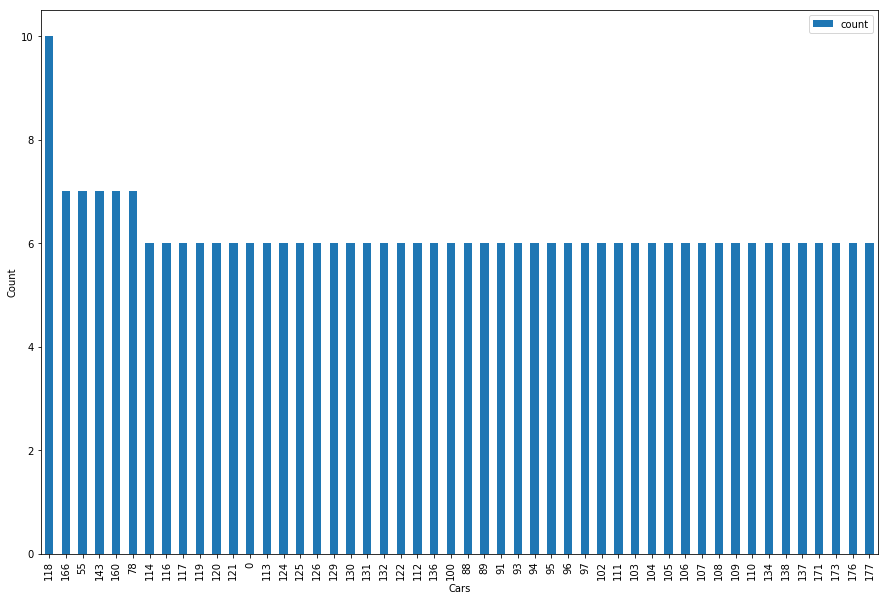

In [109]:
freq_labels = df.groupby('labels').count()[['filename']]
freq_labels = freq_labels.rename(columns={'filename': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)

freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

In [111]:
count = 0
for i,j in zip(label, pred1):
    if i==j:
        count += 1

print('Accuracy:',str(count)+'/'+str(len(label)))

Accuracy: 10/1126


# Result

In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy from using keras.evaluate_generator
print('Keras_accuracy: {0:.6f}'.format(score[1]))

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(label, pred1)
print('Accuracy: {0:.6f}'.format(accuracy))

# precision tp / (tp + fp)
precision = precision_score(label, pred1, labels=np.unique(pred1), average = 'micro')
print('Precision: {0:.6f}'.format(precision))

# recall: tp / (tp + fn)
recall = recall_score(label, pred1, labels=np.unique(pred1), average = 'micro')
print('Recall: {0:.6f}'.format(recall))

# f1: 2*(Recall * Precision) / (Recall + Precision)
f1 = f1_score(label, pred1, labels=np.unique(pred1), average= 'weighted')
print('F1: {0:.6f}'.format(f1))

Keras_accuracy: 0.793333
Accuracy: 0.008881
Precision: 0.008881
Recall: 0.008929
F1: 0.007560
